In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, precision_score, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier

from sklearn.base import BaseEstimator, ClassifierMixin

class KerasDenseModel(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, epochs=40, batch_size=32, verbose=0):
        self.input_dim = input_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model_ = None
        self.classes_ = None

    def build_model(self):
        model = keras.Sequential([
            keras.layers.Input(shape=(self.input_dim,)),
            keras.layers.Dense(512),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(256),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

    def fit(self, X, y):
        # Chuyển đổi X, y sang NumPy array nếu cần
        if isinstance(X, pd.DataFrame):
            X_processed = X.values
        else:
            X_processed = X

        if isinstance(y, pd.Series):
            y_processed = y.values
        else:
            y_processed = y

        # Lưu trữ các lớp duy nhất từ y
        self.classes_ = np.unique(y_processed)

        self.model_ = self.build_model()
        self.model_.fit(
            X_processed, y_processed,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose
        )
        return self

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X_processed = X.values
        else:
            X_processed = X
        proba = self.model_.predict(X_processed).ravel()
        return (proba > 0.5).astype(int)

    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X_processed = X.values
        else:
            X_processed = X
        proba = self.model_.predict(X_processed).ravel()
        # Trả về xác suất cho cả hai lớp (0 và 1)
        # StackingClassifier mong đợi định dạng (n_samples, n_classes)
        return np.vstack([1 - proba, proba]).T

# --- Load và chuẩn bị dữ liệu ---
df = pd.read_csv("/content/final_features_full.csv")

X = df.drop("label", axis=1)
y = df["label"]

columns_to_scale = [
    'raised_amount_usd', 'funding_total_usd', 'raised_amount_m', 'raised_amount_b',
    'raised_amount_k', 'num_investors', 'success_rate', 'failure_rate', 'success_amount',
    'fail_amount', 'total_amount', 'avg_funding_per_investor', 'num_of_success_companies',
    'num_of_failed_companies', 'funded_at_year', 'funded_at_month', 'funded_at_day',
    'funding_total_m', 'funding_total_b', 'funding_total_k', 'company_age', 'funding_duration_days',
    'avg_funding_duration_per_round', 'funding_duration_months', 'funding_duration_years',
    'founded_at_year', 'founded_at_month', 'founded_at_day', 'first_funding_year',
    'first_funding_month', 'first_funding_day', 'last_funding_year', 'last_funding_month',
    'last_funding_day', 'top_past_sector', 'top_current_sector', 'top_future_sector', 'funding_frequency'
]

# Kiểm tra xem các cột cần scale có tồn tại trong DataFrame không
missing_cols = [col for col in columns_to_scale if col not in X.columns]
if missing_cols:
    print(f"Lỗi: Các cột sau không tìm thấy trong DataFrame X: {missing_cols}")
    exit()

scaler = StandardScaler()
X_scaled_part = pd.DataFrame(scaler.fit_transform(X[columns_to_scale]), columns=columns_to_scale, index=X.index) # Thêm index để join chính xác
X_remaining = X.drop(columns=columns_to_scale)
# Nối lại, đảm bảo index được giữ nguyên hoặc reset đồng bộ
X_final = pd.concat([X_scaled_part, X_remaining], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y) # Thêm stratify=y nếu y không cân bằng

In [8]:
# --- Khởi tạo base learners ---
input_dim = X_train.shape[1]
keras_clf = KerasDenseModel(input_dim=input_dim, epochs=40, batch_size=32, verbose=0)

base_learners = [
    ('xgb', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)),
    ('lr', LogisticRegression(max_iter=200, random_state=42)),
    ('dnn', keras_clf) # keras_clf đã được khởi tạo ở trên
]

meta_learner = LogisticRegression(random_state=42)

stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

In [9]:
# --- Huấn luyện stacking ---
print("Bắt đầu huấn luyện Stacking model...")
stacking_model.fit(X_train, y_train)
print("Huấn luyện xong!")

Bắt đầu huấn luyện Stacking model...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Huấn luyện xong!


153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Stacking Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.83      0.85       960
         1.0       0.96      0.97      0.97      3933

    accuracy                           0.94      4893
   macro avg       0.92      0.90      0.91      4893
weighted avg       0.94      0.94      0.94      4893

Precision: 0.9595579000251193
F1 Score: 0.9653778114733383
AUC: 0.9815903360454276


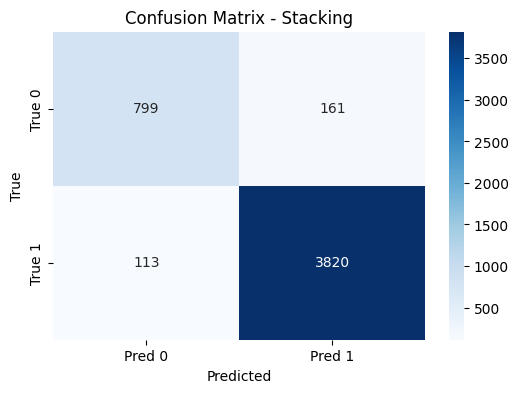

In [10]:
# --- Dự đoán ---
y_pred_stack = stacking_model.predict(X_test)
y_proba_stack = stacking_model.predict_proba(X_test)[:, 1] # Lấy xác suất của lớp dương (1)

# --- Đánh giá ---
print("\nStacking Classification Report:\n", classification_report(y_test, y_pred_stack))
print("Precision:", precision_score(y_test, y_pred_stack))
print("F1 Score:", f1_score(y_test, y_pred_stack))
print("AUC:", roc_auc_score(y_test, y_proba_stack))

# --- Ma trận nhầm lẫn ---
cm = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=keras_clf.classes_ if keras_clf.classes_ is not None else ['Pred 0', 'Pred 1'], yticklabels=keras_clf.classes_ if keras_clf.classes_ is not None else ['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Stacking')
plt.show()